In [33]:
from bayesian_optimization import BayesianOptimization
import pandas as pd 
from botorch.test_functions import Ackley
from botorch.test_functions import Levy 
from botorch.test_functions import Beale
from botorch.test_functions import DixonPrice
from botorch.test_functions import DropWave

# Variables that determine the size of the dataset
N_INITIAL = 25
EPOCHS = 5
BATCH_SIZE = 25
DIM = 10
LOWER = -10
UPPER = 10

optimizer = BayesianOptimization(fun=DixonPrice(dim=DIM,negate=True), 
                                 batch_size=BATCH_SIZE, 
                                 dim=DIM, 
                                 epochs=EPOCHS, 
                                 n_init=N_INITIAL, 
                                 lower_bound=LOWER,
                                 upper_bound=UPPER,
                                 seed=5,
                                 acqf_type='qUCB')

x_max, y_max = optimizer.run()
data = optimizer.get_data()
full = optimizer.format(data, dim=DIM, n_init=N_INITIAL, batch_size=BATCH_SIZE, epochs=EPOCHS)
display(full)

,Batch,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.0,-0.394189,-7.654822,-7.520206,-3.075355,-5.730497,0.962927,-1.483629,8.630562,2.681789,-1.423116,-279678.181294
1,0.0,3.434330,3.455671,5.146151,7.454337,0.236528,-6.415740,8.006977,-9.150647,-5.981693,8.109157,-671835.461359
2,0.0,9.718981,-2.770988,-1.765026,-8.754016,6.206315,-0.010172,-9.608257,-0.051369,-4.578974,3.126919,-394643.402196
3,0.0,-6.452973,8.649638,4.300369,0.642744,-0.404786,7.377052,1.131774,2.182651,6.591529,-7.342867,-290664.864835
4,0.0,-7.908526,-1.892475,9.471689,3.885680,-4.633258,3.195376,-6.710665,-3.950132,-2.399340,5.628018,-221979.415251
...,...,...,...,...,...,...,...,...,...,...,...,...
145,5.0,-4.831583,-1.457051,0.661847,7.982047,6.790291,-8.900803,5.175622,-9.234054,-8.966469,5.983804,-809161.133748
146,5.0,7.816256,-8.408928,2.000634,-2.819795,-8.260148,4.863308,-8.343594,5.799269,2.195176,0.227303,-325136.346080
147,5.0,-8.053695,2.484746,6.614178,-3.991596,-1.952055,-1.941447,6.650345,-9.969329,3.730233,6.335673,-450314.084501
148,5.0,-2.053049,3.776895,-3.136456,-8.186060,6.230524,-9.151898,1.404199,-0.214873,5.577238,3.918522,-313397.567824


In [38]:
import pandas as pd
cols = ['Batch','y']
df = full[cols]


y_0 = df[df['Batch'] == 0.0][['y']]
y_1 = df[df['Batch'] == 1.0][['y']]


def get_batches(id1,id2):
    y_0 = df[df['Batch'] == id1][['y']].to_numpy()
    y_1 = df[df['Batch'] == id2][['y']].to_numpy()
    return y_0, y_1
X, Y = get_batches(id1=2,id2=0)

print(X.shape, Y.shape)

(25, 1) (25, 1)


In [39]:
import numpy as np

def permutation_test_max(X, Y, n_permutations=10000):
    np.random.seed(0)
    combined = np.concatenate([X, Y])
    n_X = len(X)
    obs_diff = np.max(X) - np.max(Y)
    
    perm_diffs = []
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        X_permuted = combined[:n_X]
        Y_permuted = combined[n_X:]
        max_diff = np.max(X_permuted) - np.max(Y_permuted)
        perm_diffs.append(max_diff)
        
    p_value = np.mean(perm_diffs > obs_diff)
    return np.array(perm_diffs), obs_diff, p_value

# Normalize the data if scales are different
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X.reshape(-1, 1)).flatten()
Y_normalized = scaler.fit_transform(Y.reshape(-1, 1)).flatten()

# Permutation test
perm_diffs, obs_diff_perm, p_value = permutation_test_max(X, Y)

print(f"Permutation Observed difference of maxima (normalized): {obs_diff_perm}")
print(f"Permutation p-value (normalized): {p_value}")

Permutation Observed difference of maxima (normalized): 126772.82588278044
Permutation p-value (normalized): 0.0002


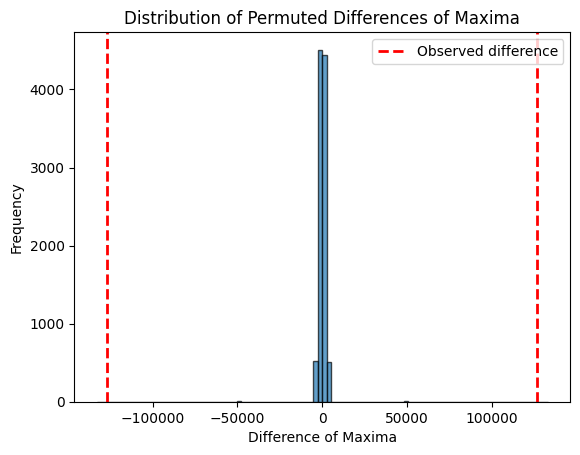

In [42]:
import matplotlib.pyplot as plt

plt.hist(perm_diffs, bins=100, edgecolor='k', alpha=0.7)
plt.axvline(obs_diff_perm, color='r', linestyle='--', linewidth=2, label='Observed difference')
plt.axvline(-obs_diff_perm, color='r', linestyle='--', linewidth=2)
plt.title('Distribution of Permuted Differences of Maxima')
plt.xlabel('Difference of Maxima')
plt.ylabel('Frequency')
plt.legend()
plt.show()